In [ ]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pickle

In [ ]:
!pwd

/content


In [ ]:
!cd drive/MyDrive/Datasets
# cd some_directory, it only affects that specific cell.

os.chdir('drive/MyDrive/Datasets')
!pwd

/content/drive/MyDrive/Datasets


In [ ]:
if  not os.path.exists('kaggle.json'):
  from google.colab import files
  files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                        title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
mosapabdelghany/medical-insurance-cost-dataset             Medical Insurance Cost Dataset                          16425  2025-08-24 11:54:36.533000          14286        282  1.0              
zadafiyabhrami/global-crocodile-species-dataset            Global Crocodile Species Dataset                        57473  2025-08-26 08:46:11.950000           9416        268  1.0              
codebynadiia/gdp-per-country-20202025                      GDP per Country 2020–2025                                5677  2025-09-04 14:37:43.563000           7771        151  1.0              
saadaliyaseen/analyzing-studen

In [ ]:
# download the dataset into the directory you switched to using os.chdir() in Python
# and not the current working directory of the shell, which is usually /content

if not os.path.exists("signature-verification-dataset"):
  !kaggle datasets download -d robinreni/signature-verification-dataset -p {os.getcwd()}
  !unzip signature-verification-dataset.zip -d signature-verification-dataset
  !rm signature-verification-dataset.zip

In [ ]:
source_dataset_path = os.path.join(os.getcwd(), "signature-verification-dataset", "sign_data")

In [ ]:
organized_dataset_path = os.path.join(os.getcwd(), 'signature-verification-organized')
train_dataset_path = os.path.join(organized_dataset_path, 'Train')
test_dataset_path = os.path.join(organized_dataset_path, 'Test')

if not os.path.exists(organized_dataset_path):
  for path in {train_dataset_path, test_dataset_path}:
    ! mkdir -p {os.path.join(path, 'Genuine')}
    ! mkdir -p {os.path.join(path, 'Forged')}

  source_dataset_train_path = os.path.join(source_dataset_path, 'train')
  for dir in os.listdir(source_dataset_train_path):
    source = os.path.join(source_dataset_train_path, dir)
    if dir.endswith("_forg"):
      destination = os.path.join(train_dataset_path, 'Forged')
    else:
      destination = os.path.join(train_dataset_path, "Genuine")
    print(f"Copying {dir} to {destination}")
    shutil.copytree(source, destination, dirs_exist_ok=True)

  source_dataset_test_path = os.path.join(source_dataset_path, 'test')
  for dir in os.listdir(source_dataset_test_path):
    source = os.path.join(source_dataset_test_path, dir)
    if dir.endswith("_forg"):
      destination = os.path.join(test_dataset_path, 'Forged')
    else:
      destination = os.path.join(test_dataset_path, "Genuine")
    print(f"Copying {dir} to {destination}")
    shutil.copytree(source, destination, dirs_exist_ok=True)

In [ ]:
train_validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    # brightness_range = (0.8, 1.2),
    shear_range = 0.2,
    zoom_range = (0.8, 1.2),
    # channel_shift_range= 20,
    fill_mode = 'nearest'
)

batch_size_train = 32
batch_size_valid = 16

train_data_generator = train_validation_data_generator.flow_from_directory(
    train_dataset_path,
    target_size = (128, 128),
    batch_size = batch_size_train,
    class_mode = 'binary',
    subset = 'training'
)

validation_data_generator = train_validation_data_generator.flow_from_directory(
    train_dataset_path,
    target_size = (128, 128),
    batch_size = batch_size_valid,
    class_mode = 'binary',
    subset = 'validation'
)

Found 1320 images belonging to 2 classes.
Found 329 images belonging to 2 classes.


Label :  0.0


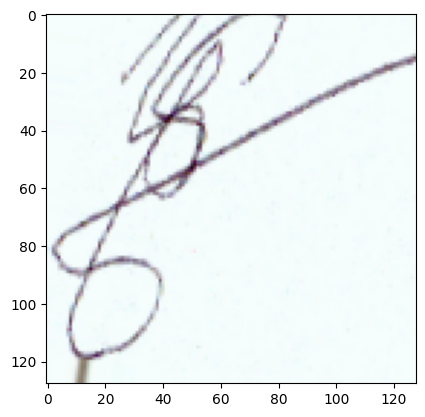

In [ ]:
plt.imshow(train_data_generator[0][0][0])
print("Label : ", train_data_generator[0][1][0])

Label :  0.0


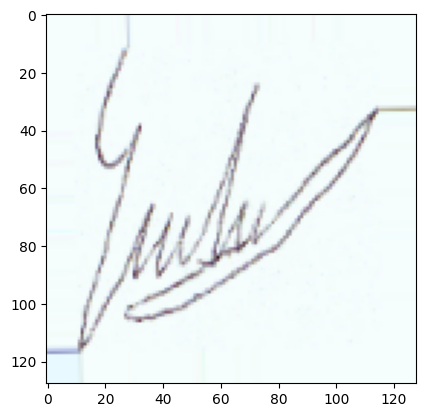

In [ ]:
plt.imshow(validation_data_generator[0][0][0])
print("Label : ", validation_data_generator[0][1][0])

In [ ]:
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights='imagenet',
    input_shape=(128, 128, 3)
)

base_model.trainable = False

n=len(base_model.layers)
base_model.layers[n-1].trainable=True
# base_model.layers[n-2].trainable=True
# base_model.layers[n-3].trainable=True
# base_model.layers[n-4].trainable=True

encoder = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation('relu'),
    #tf.keras.layers.Dropout(0.1),

    # tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Activation('relu'),
    # tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.3),
])

model = tf.keras.Sequential([
    base_model,
    #tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    encoder,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, decay=1e-6),
              metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ (None, 4, 4, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64)             │     1,048,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,277,825 (16.32 MB)

 Trainable params: 1,048,833 (4.00 MB)

 Non-trainable params: 3,228,992 (12.32 MB)

In [ ]:
history = model.fit(
    train_data_generator,
    epochs=1000,
    validation_data=validation_data_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 909ms/step - accuracy: 0.6681 - loss: 0.7393 - val_accuracy: 0.5653 - val_loss: 1.5386
Epoch 2/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 39s 925ms/step - accuracy: 0.8473 - loss: 0.4950 - val_accuracy: 0.6626 - val_loss: 1.1514
Epoch 3/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 847ms/step - accuracy: 0.9003 - loss: 0.3837 - val_accuracy: 0.6748 - val_loss: 1.1111
Epoch 4/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 844ms/step - accuracy: 0.9148 - loss: 0.3580 - val_accuracy: 0.6869 - val_loss: 1.0324
Epoch 5/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 820ms/step - accuracy: 0.9617 - loss: 0.2970 - val_accuracy: 0.7690 - val_loss: 0.7720
Epoch 6/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 37s 876ms/step - accuracy: 0.9412 - loss: 0.3018 - val_accuracy: 0.7629 - val_loss: 0.7208
Epoch 7/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 35s 823ms/step - accuracy: 0.9611 - loss: 0.2818 - val_accuracy: 0.7812 - val_loss: 0.6661
Epoch 8/1000
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 843ms/step - accuracy: 0.9601 - loss: 0

In [ ]:
History = model.history

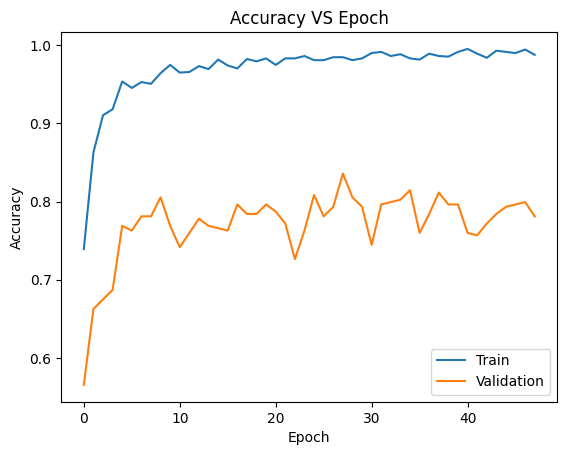

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Accuracy VS Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

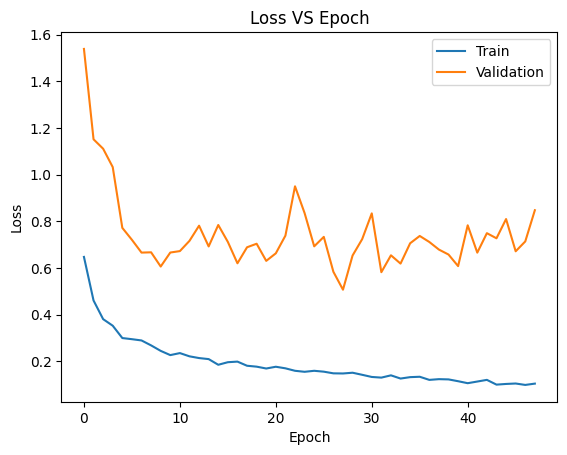

In [ ]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Loss VS Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
batch_size_test = 32

test_data_generator = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dataset_path,
                                                                    target_size = (128,128),
                                                                    batch_size = batch_size_test,
                                                                    class_mode = 'binary')

Found 500 images belonging to 2 classes.


In [ ]:
model.evaluate(test_data_generator)

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 583ms/step - accuracy: 0.9909 - loss: 0.1190


[0.11852774769067764, 0.9919999837875366]

In [ ]:
y_pred = model.predict(test_data_generator)
y_pred_labels = (y_pred > 0.5).astype(int)

y_true = test_data_generator.classes

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step


In [ ]:
cm = confusion_matrix(y_true, y_pred_labels)
print(cm)

[[119 129]
 [133 119]]


In [ ]:
cr = classification_report(y_true, y_pred_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.47      0.48      0.48       248
           1       0.48      0.47      0.48       252

    accuracy                           0.48       500
   macro avg       0.48      0.48      0.48       500
weighted avg       0.48      0.48      0.48       500



In [ ]:
os.chdir('/content/drive/My Drive/')
model.save('Model64-new.keras')

* The Signature Verification Dataset on Kaggle — often labeled as the Offline Signature Verification Dataset — contains 2,149 images.
* The data are sourced from the ICDAR 2011 Signature Dataset, including both genuine and forged signatures from Dutch users.
* The official ICDAR 2011 dataset comprises 2,294 Dutch offline signature images, with 362 used for training and 1,932 for testing. It also features Chinese signature samples, available in both offline image and online dynamic formats.